# Summary

This notebook runs CellChat for the Mouse PDAC Data. Part 1 is for CellChat analysis on separate datasets (separated by genotype - AKPC and KPC), and Part 2 is for CellChat analysis on a merged CellChat object for comparative analysis. 

In [2]:
options(warn=-1)
suppressMessages(library(hdf5r))
suppressMessages(library(Seurat))
suppressMessages(library(Signac))
suppressMessages(library(EnsDb.Mmusculus.v79))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(Matrix))
suppressMessages(library(harmony))
suppressMessages(library(data.table))
suppressMessages(library(ggpubr))
suppressMessages(library(plyr))
suppressMessages(library(sparseMatrixStats))
suppressMessages(library(stringr))
suppressMessages(library(CellChat))
suppressMessages(library(patchwork))
suppressMessages(library(umap))
suppressMessages(library(ComplexHeatmap))
suppressMessages(library(pheatmap))
suppressMessages(library(NMF))
suppressMessages(library(ggalluvial))
suppressMessages(library(RColorBrewer))

# Load merged object and subset (if needed)

If you already have separate datasets, skip this section and jump to "Part I: Data Input & processing and initialization of CellChat Object". In this notebook, I loaded in a merged object to subset by genotype to create separate datasets.

In [2]:
# Load in merged adata object
adata <- readRDS("/nfs/lab/projects/mouse_pdac/230918_2sample_merged_with_celltypes_CAFs_no_mito.rds")

# Part I: Data Input & processing and initialization of CellChat Object

### All run for APKC - repeat for KPC

In [ ]:
# Subset to each genotype (AKPC vs KPC)
adata_akpc <- subset(adata, subset = Genotype == "AKPC")
DefaultAssay(adata_akpc) <- "RNA"

## Create a CellChat Object

Run CellChat on each dataset separately. (In this notebook, the different datasets are separated by genotype, AKPC and KPC).

In [ ]:
## Access normalized data matrix
adata_akpc <- NormalizeData(adata_akpc)
data.input <- adata_akpc$RNA

## A dataframe with rownamees containing cell metadata
meta <- adata_akpc@meta.data
cell.use = rownames(meta)

data.input = data.input[, cell.use]
meta = meta[cell.use ,]

## Create CellChat Object
cellchat_akpc <- createCellChat(object = data.input, meta = meta, group.by = "Fibroblasts")

### Set celltype colors

In [ ]:
celltype_colors <- c('Acinar cells'='#251351', 'B cells'='#3B52A5', 'Dendritic cells'='#5AB1BB', 
                     'Ductal cells'='#618040', 'EMT-like cells'='#AFE079', 'Endothelial cells'='#FF773D',
                     'Macrophages'='#CAA9DE', 'Neutrophils'='#D84727',
                     'Perivascular cells'='#EDA2C0', 'T and NK cells'='#E3C15D', 'myCAF'='#710CAB',
                     'apCAF'='#4FF0E0', 'iCAF'='#C2C0C0')

### Set the ligand-receptor interaction database

In [ ]:
CellChatDB <- CellChatDB.mouse

In [ ]:
# Show the structure of the database
dplyr::glimpse(CellChatDB$interaction)

# use a subset of CellChatDB for cell-cell communication analysis
CellChatDB.use <- subsetDB(CellChatDB, search = "Secreted Signaling") # use Secreted Signaling

# set the used database in the object
cellchat_akpc@DB <- CellChatDB.use

### Preprocessing the expression data for cell-cell communication analysis

In [ ]:
# subset the expression data of signaling genes for saving computation cost
cellchat_akpc <- subsetData(cellchat_akpc) # This step is necessary even if using the whole database
future::plan("multisession", workers = 4) # do parallel

cellchat_akpc <- identifyOverExpressedGenes(cellchat_akpc)
cellchat_akpc <- identifyOverExpressedInteractions(cellchat_akpc)

# Part II: Inference of cell-cell communication network

### Compute the communication probability and infer cellular communication network

In [13]:
cellchat_akpc <- computeCommunProb(cellchat_akpc)

triMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on sc/snRNA-seq data <<< [2024-01-16 11:37:56]"
[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2024-01-16 11:46:51]"


In [14]:
# Filter out the cell-cell communication if there are only few number of cells in certain cell groups
cellchat_akpc <- filterCommunication(cellchat_akpc, min.cells = 10)

In [15]:
# Extract the inferred cellular communication network as a data frame
df.net <- subsetCommunication(cellchat_akpc)

### Infer the cell-cell communication at a signaling pathway level

In [16]:
slot.name = "netP"
cellchat_akpc <- computeCommunProbPathway(cellchat_akpc)

In [17]:
# Calculate the aggregated cell-cell communication network by counting
## the number of links or summarizing the communication probability.
cellchat_akpc <- aggregateNet(cellchat_akpc)

In [44]:
groupSize <- as.numeric(table(cellchat_akpc@idents))
par(mfrow = c(1,2), xpd=TRUE)

# # Prints out a circle plot showing number of interactions for all celltypes
# netVisual_circle(cellchat_akpc@net$count, vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Number of interactions")

# # Prints out a circle plot showing interaction weights/strength for all celltypes
# netVisual_circle(cellchat_akpc@net$weight, vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Interaction weights/strength")

In [25]:
mat <- cellchat_akpc@net$weight
par(mfrow = c(1,1), xpd=TRUE)

# # Prints out a circle plot showing interaction strength for each celltype separately
# for (i in 1:nrow(mat)) {
#   mat2 <- matrix(0, nrow = nrow(mat), ncol = ncol(mat), dimnames = dimnames(mat))
#   mat2[i, ] <- mat[i, ]
#   netVisual_circle(mat2, vertex.weight = groupSize, weight.scale = T, edge.weight.max = max(mat), title.name = rownames(mat)[i], color.use = celltype_colors)
# }

# Part III: Visualization of cell-cell communication network

In [27]:
pathways.show <- c("TGFb") 

In [47]:
# Chord diagram
par(mfrow=c(1,1))

# # Prints out a chord plot showing cell-cell communication network between celltypes
# netVisual_aggregate(cellchat_akpc, signaling = pathways.show, layout = "chord", color.use = celltype_colors)

Plot the aggregated cell-cell communication network at the signaling pathway level



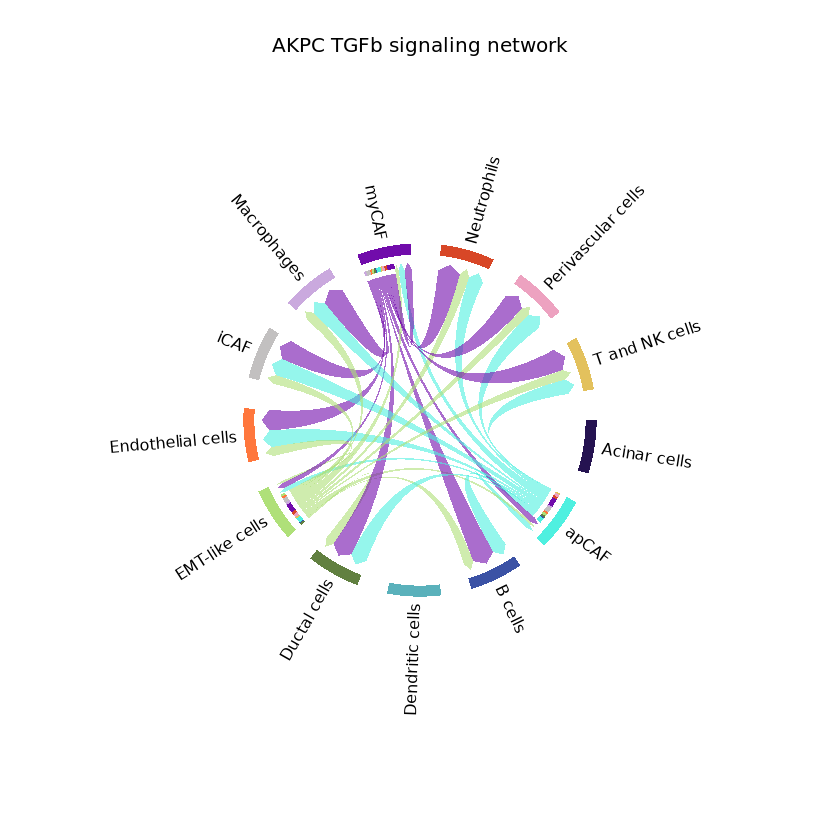

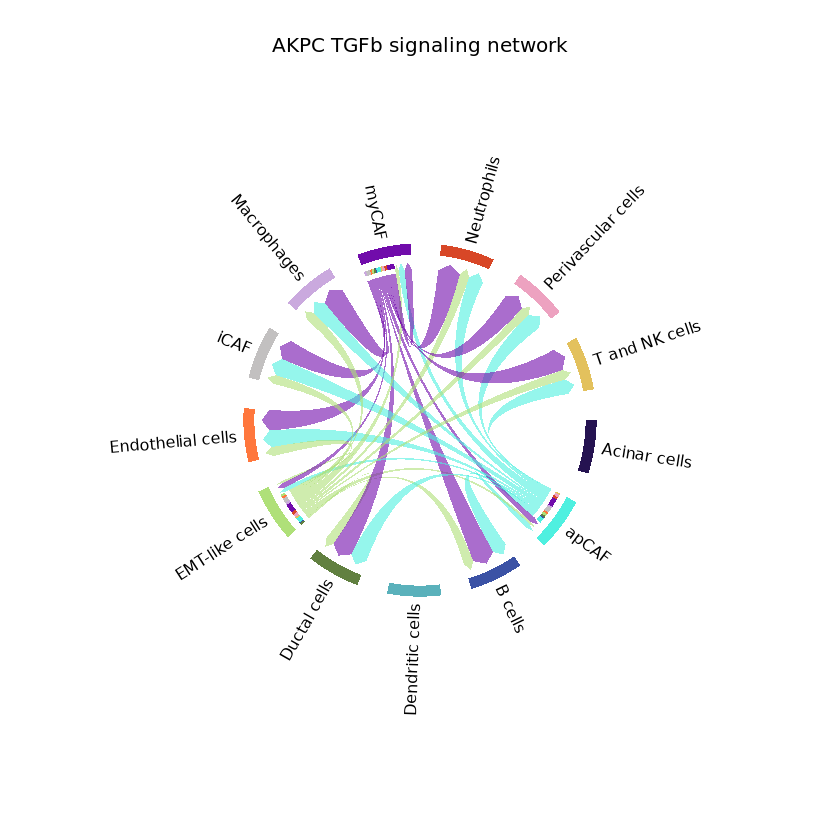

In [31]:
# Chord diagram
group.cellType <- levels(cellchat_akpc@idents) # grouping cell clusters
names(group.cellType) <- levels(cellchat_akpc@idents)

# Prints out a chord plot showing the TGFb signaling network for AKPC 
netVisual_chord_cell(cellchat_akpc, signaling = pathways.show, group = group.cellType, title.name = paste0("AKPC ", pathways.show, " signaling network"), color.use=celltype_colors)
#> Plot the aggregated cell-cell communication network at the signaling pathway level

In [32]:
# Access all the signaling pathways showing significant communications
pathways.show.all <- cellchat_akpc@netP$pathways
# check the order of cell identity to set suitable vertex.receiver
# levels(cellchat_akpc@idents)
vertex.receiver = seq(1,4)
for (i in 1:length(pathways.show.all)) {
  # Visualize communication network associated with both signaling pathway and individual L-R pairs
  netVisual(cellchat_akpc, signaling = pathways.show.all[i], vertex.receiver = vertex.receiver, layout = "hierarchy")
  # Compute and visualize the contribution of each ligand-receptor pair to the overall signaling pathway
  gg <- netAnalysis_contribution(cellchat_akpc, signaling = pathways.show.all[i])
  ggsave(filename=paste0(pathways.show.all[i], "_L-R_contribution.pdf"), plot=gg, width = 3, height = 2, units = 'in', dpi = 300)
}

### Visualize cell-cell communication mediated by multiple ligand receptors or signaling pathways

In [33]:
# # Show all the significant interactions (L-R pairs) from some cell groups (defined by 'sources.use') to other cell groups (defined by 'targets.use')
# netVisual_chord_gene(cellchat_akpc, sources.use = c(1,2,3,4), targets.use = 8, legend.pos.x = 15,color.use=celltype_colors)

### Plot the signaling gene expression distribution using violin/dot plot

By default, plotGeneExpression only shows the expression of signaling genes related to the inferred significant communications. USERS can show the expression of all signaling genes related to one signaling pathway by using `enriched.only = FALSE`


In [50]:
# Prints a violin plot showing the signaling gene expression distribution
gg1 <- plotGeneExpression(cellchat_akpc, signaling = "TGFb", color.use=celltype_colors)
# gg1

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


# Part IV: Systems analysis of cell-cell communication network

In [34]:
# Compute the network centrality scores -- the slot 'netP' means the inferred intercellular communication network of signaling pathways
cellchat_akpc <- netAnalysis_computeCentrality(cellchat_akpc, slot.name = "netP")

# # Visualize the computed centrality scores using heatmap, allowing ready identification of major signaling roles of cell groups
# netAnalysis_signalingRole_network(cellchat_akpc, signaling = pathways.show, width = 8, height = 2.5, font.size = 10, color.use=celltype_colors)

In [35]:
# Signaling role analysis on the aggregated cell-cell communication network from all signaling pathways
gg1 <- netAnalysis_signalingRole_scatter(cellchat_akpc)

# Signaling role analysis on the cell-cell communication networks of interest
gg2 <- netAnalysis_signalingRole_scatter(cellchat_akpc, signaling = c("TGFb"), color.use=celltype_colors)
# gg1 + gg2

Signaling role analysis on the aggregated cell-cell communication network from all signaling pathways

Signaling role analysis on the cell-cell communication network from user's input



In [52]:
# Signaling role analysis on the cell-cell communication networks of interest
ht <- netAnalysis_signalingRole_heatmap(cellchat_akpc, signaling = c("TGFb"))

# # Prints out a heatmap for outgoing signaling patterns
# ht

### Identify global communication patterns to explore how multiple celltypes and signaling pathways coordinate together

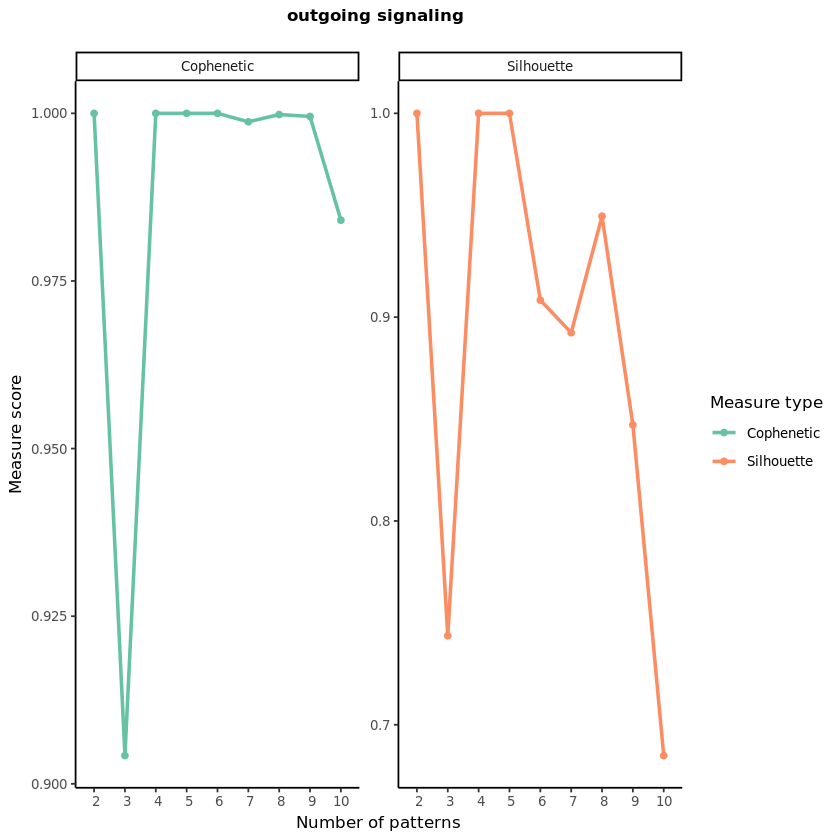

In [37]:
selectK(cellchat_akpc, pattern = "outgoing")

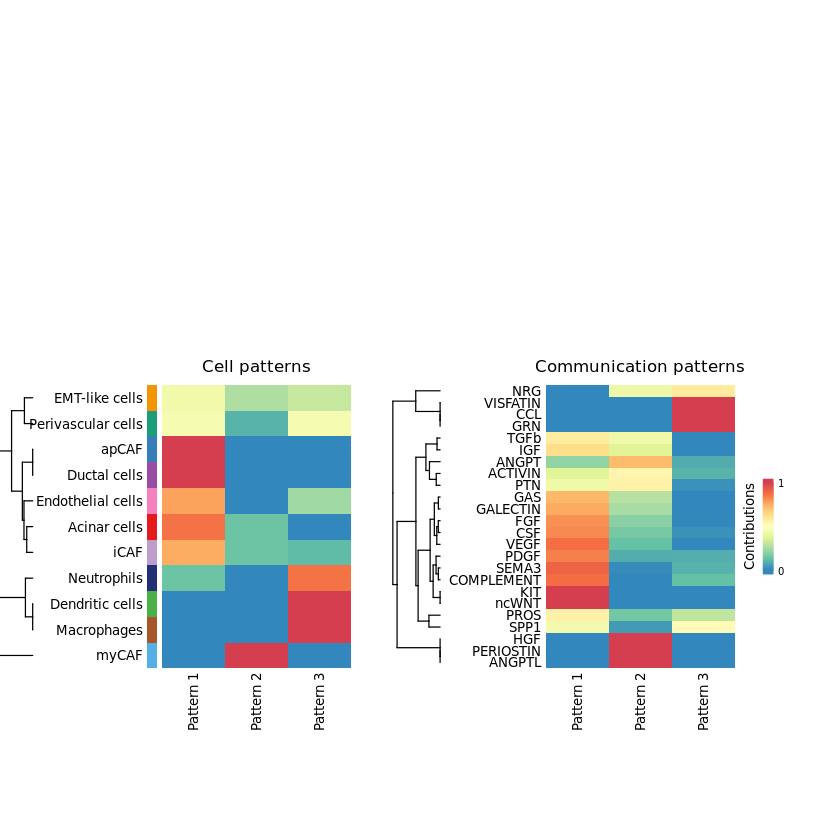

In [38]:
nPatterns = 3
cellchat_akpc <- identifyCommunicationPatterns(cellchat_akpc, pattern = "outgoing", k = nPatterns)

In [53]:
# Prints a river plot showing the outgoing communication patterns of secreting cells
gg1 <- netAnalysis_river(cellchat_akpc, pattern = "outgoing")
# gg1

# Prints a dotplot showing the outgoing communication patterns of secreting cell
gg2 <- netAnalysis_dot(cellchat_akpc, pattern = "outgoing")
# gg2

Please make sure you have load `library(ggalluvial)` when running this function



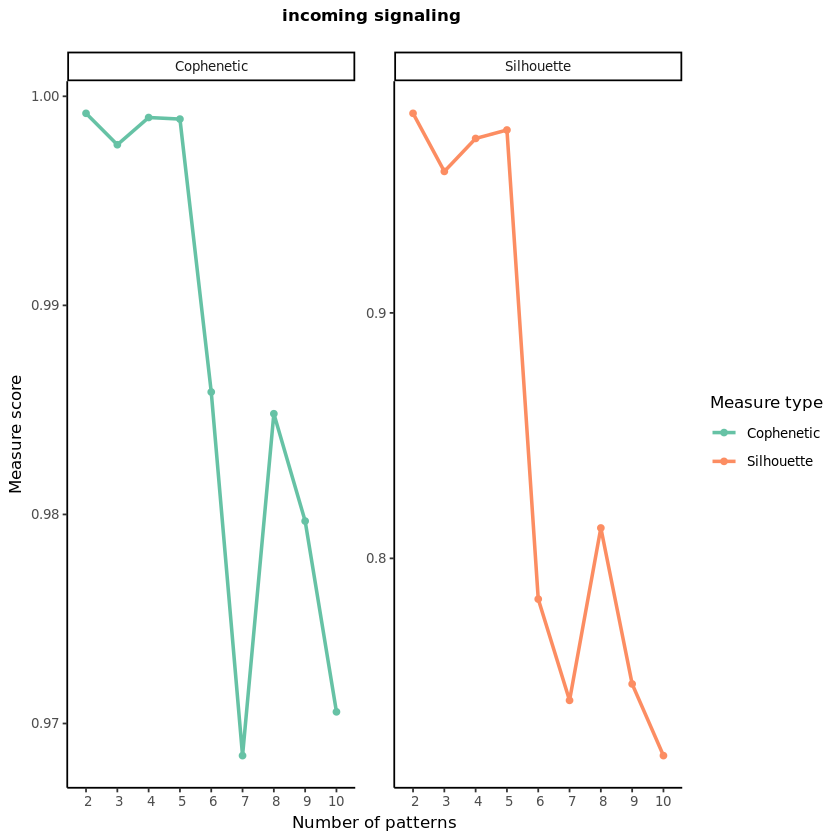

In [54]:
selectK(cellchat_akpc, pattern = "incoming")

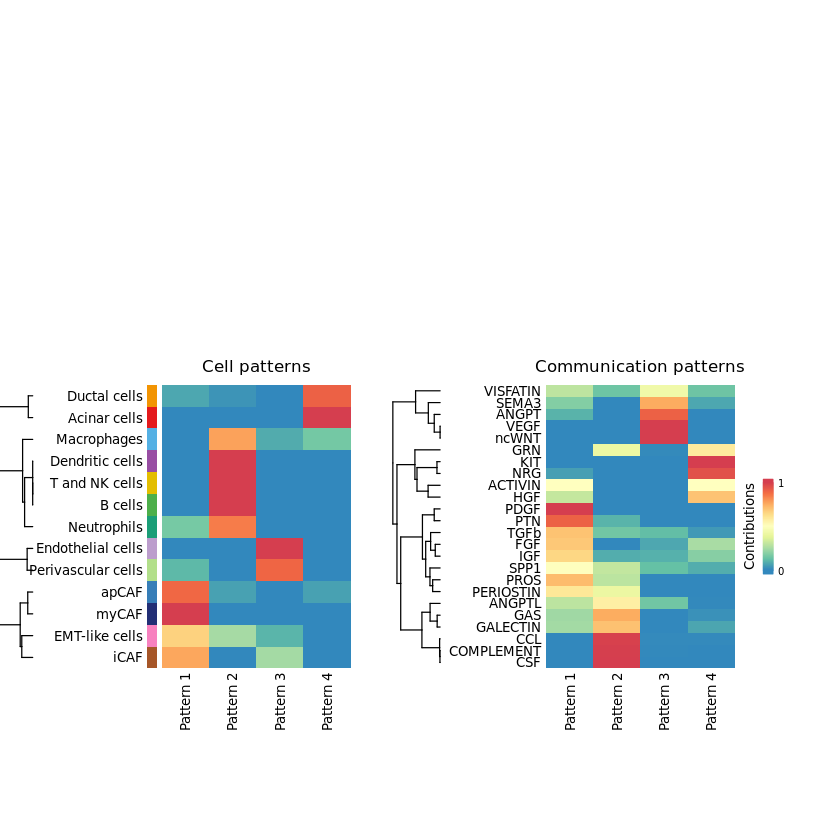

In [55]:
nPatterns = 4
cellchat_akpc <- identifyCommunicationPatterns(cellchat_akpc, pattern = "incoming", k = nPatterns)

In [56]:
# Prints a river plot showing incoming communication patterns of target cells
gg1 <- netAnalysis_river(cellchat_akpc, pattern = "incoming")
# gg1

# Prints a dotplot showing incoming communication patterns of target cells
gg2 <- netAnalysis_dot(cellchat_akpc, pattern = "incoming")
# gg2

Please make sure you have load `library(ggalluvial)` when running this function



# Part V: Save the CellChat Object

In [55]:
# Change output dir
outdir <- '/nfs/lab/projects/mouse_pdac/cellchat'
rds_fp2 <- file.path(outdir,'230920_AKPC_cellchat.rds')
saveRDS(cellchat_akpc, file = rds_fp2)

# Section 2:  Comparison analysis of Multiple Datasets using CellChat

In this section, we read in the RDS for the different datasets and merge them into one cellchat object to run comparative analysis. 

### Load CellChat object of each dataset and merge together

In [4]:
object.list <- list(AKPC = cellchat_akpc, KPC = cellchat_kpc)
cellchat <- mergeCellChat(object.list, add.names = names(object.list))

Merge the following slots: 'data.signaling','images','net', 'netP','meta', 'idents', 'var.features' , 'DB', and 'LR'.



# Part I: Predict general principles of cell-cell communication

In [5]:
# Compare the total number of interactions and interaction strength in a barplot
gg1 <- compareInteractions(cellchat, show.legend = F, group = c(1,2))
gg2 <- compareInteractions(cellchat, show.legend = F, group = c(1,2), measure = "weight")
# gg1 + gg2

In [6]:
# Differential number of interactions or interaction strength among different cell populations
par(mfrow = c(1,1), xpd=TRUE)
# netVisual_diffInteraction(cellchat, weight.scale = T)
# netVisual_diffInteraction(cellchat, weight.scale = T, measure = "weight")

In [66]:
gg1 <- netVisual_heatmap(cellchat)
# gg1

Do heatmap based on a merged object 




In [67]:
gg2 <- netVisual_heatmap(cellchat, measure = "weight")
# gg2

Do heatmap based on a merged object 




In [7]:
# Shows number of interactions for AKPC and KPC
weight.max <- getMaxWeight(object.list, attribute = c("idents","count"))
par(mfrow = c(1,1), xpd=TRUE)
# for (i in 1:length(object.list)) {
#   netVisual_circle(object.list[[i]]@net$count, weight.scale = T, label.edge= F, edge.weight.max = weight.max[2], edge.width.max = 12, title.name = paste0("Number of interactions - ", names(object.list)[i]))
# }

In [8]:
# Shows outgoing interaction strength for AKPC and KPC
num.link <- sapply(object.list, function(x) {rowSums(x@net$count) + colSums(x@net$count)-diag(x@net$count)})
weight.MinMax <- c(min(num.link), max(num.link)) # control the dot size in the different datasets
gg <- list()
for (i in 1:length(object.list)) {
  gg[[i]] <- netAnalysis_signalingRole_scatter(object.list[[i]], title = names(object.list)[i], weight.MinMax = weight.MinMax)
}
# patchwork::wrap_plots(plots = gg)

Signaling role analysis on the aggregated cell-cell communication network from all signaling pathways

Signaling role analysis on the aggregated cell-cell communication network from all signaling pathways



# Part II: Identify the conserved and context-specific signaling pathways

In [11]:
# Shows a barplot showing relative information flow and information flow
gg1 <- rankNet(cellchat, mode = "comparison", stacked = T, do.stat = TRUE)
gg2 <- rankNet(cellchat, mode = "comparison", stacked = F, do.stat = TRUE)
# gg1 + gg2

In [12]:
# Prints a heatmap showing outgoing signaling patterns for AKPC 
i = 1
options(repr.plot.width=5, repr.plot.height=5)
# combining all the identified signaling pathways from different datasets 
pathway.union <- union(object.list[[i]]@netP$pathways, object.list[[i+1]]@netP$pathways)
ht1 = netAnalysis_signalingRole_heatmap(object.list[[i]], pattern = "outgoing", signaling = pathway.union, title = names(object.list)[i], width = 5, height = 6)
ht2 = netAnalysis_signalingRole_heatmap(object.list[[i+1]], pattern = "outgoing", signaling = pathway.union, title = names(object.list)[i+1], width = 5, height = 6)
# ht1

In [13]:
# Prints a heatmap showing outgoing signaling patterns for KPC 
# ht2

In [14]:
# Prints a heatmap showing incoming signaling patterns for AKPC 
ht1 = netAnalysis_signalingRole_heatmap(object.list[[i]], pattern = "incoming", signaling = pathway.union, title = names(object.list)[i], width = 5, height = 6, color.heatmap = "GnBu")
ht2 = netAnalysis_signalingRole_heatmap(object.list[[i+1]], pattern = "incoming", signaling = pathway.union, title = names(object.list)[i+1], width = 5, height = 6, color.heatmap = "GnBu")
# ht1

In [15]:
# Prints a heatmap showing incoming signaling patterns for KPC 
# ht2

In [17]:
# Prints a heatmap showing overall signaling patterns for AKPC 
ht1 = netAnalysis_signalingRole_heatmap(object.list[[i]], pattern = "all", signaling = pathway.union, title = names(object.list)[i], width = 5, height = 6, color.heatmap = "OrRd")
ht2 = netAnalysis_signalingRole_heatmap(object.list[[i+1]], pattern = "all", signaling = pathway.union, title = names(object.list)[i+1], width = 5, height = 6, color.heatmap = "OrRd")
# ht1

In [16]:
# Prints a heatmap showing overall signaling patterns for KPC 
# ht2

In [18]:
# Shows the TGFb signaling pathway network for AKPC and KPC
pathways.show <- c("TGFb") 
weight.max <- getMaxWeight(object.list, slot.name = c("netP"), attribute = pathways.show) # control the edge weights across different datasets
par(mfrow = c(1,1), xpd=TRUE)
# for (i in 1:length(object.list)) {
#   netVisual_aggregate(object.list[[i]], signaling = pathways.show, layout = "circle", edge.weight.max = weight.max[1], edge.width.max = 10, signaling.name = paste(pathways.show, names(object.list)[i]))
# }

In [21]:
pathways.show <- c("TGFb") 
par(mfrow = c(1,2), xpd=TRUE)
ht <- list()
for (i in 1:length(object.list)) {
  ht[[i]] <- netVisual_heatmap(object.list[[i]], signaling = pathways.show, color.heatmap = "Reds",title.name = paste(pathways.show, "signaling ",names(object.list)[i]))
}

Do heatmap based on a single object 


Do heatmap based on a single object 




In [22]:
# Prints a heatmap showing  TGFb signaling for AKPC
# ht[[1]]

In [23]:
# Prints a heatmap showing  TGFb signaling for KPC
# ht[[2]]

In [24]:
# Chord diagram showing the TGFb signaling pathway network for AKPC and KPC
pathways.show <- c("TGFb") 
par(mfrow = c(1,1), xpd=TRUE)
# for (i in 1:length(object.list)) {
#   netVisual_aggregate(object.list[[i]], signaling = pathways.show, layout = "chord", signaling.name = paste(pathways.show, names(object.list)[i]))
# }

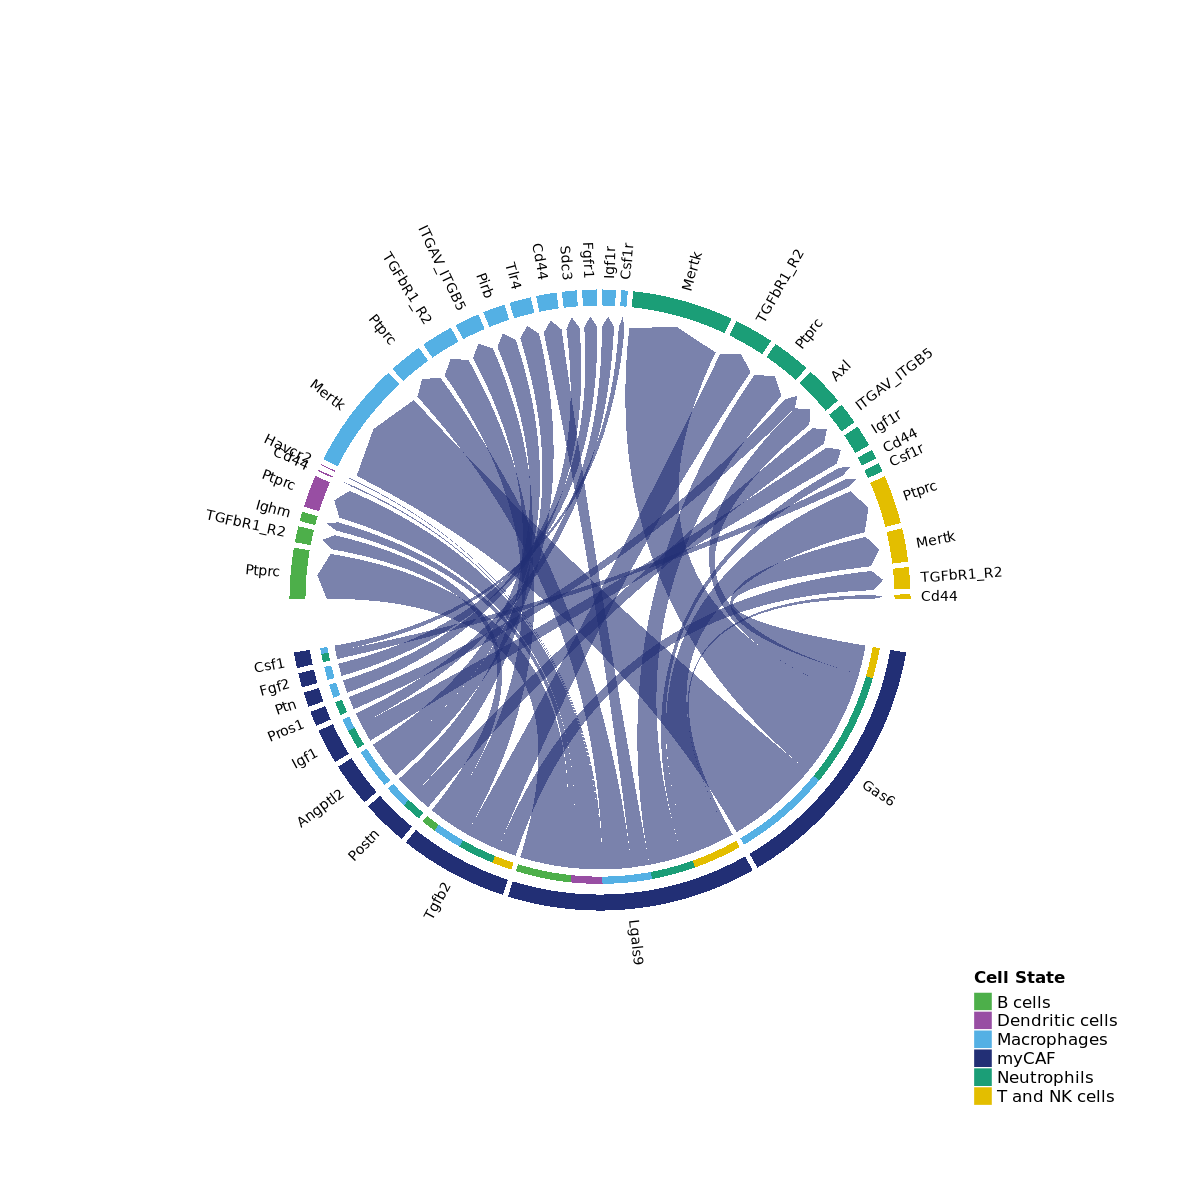

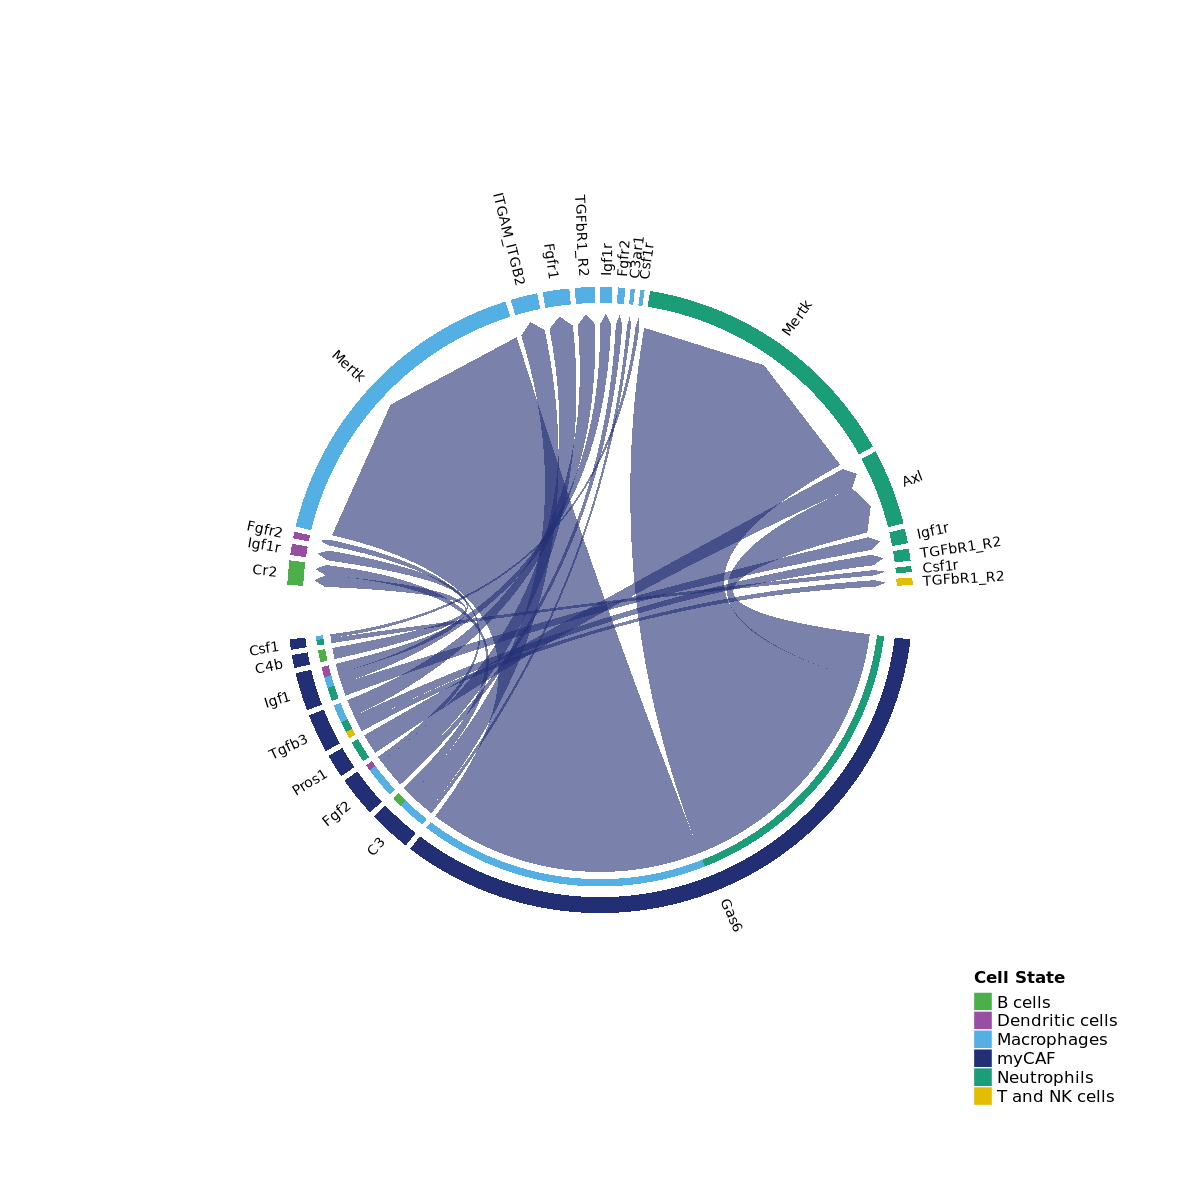

In [25]:
plot_width <- 10  # Adjust as needed
plot_height <- 10

par(mfrow = c(1, 1), xpd=TRUE)

## can adjust sources.use and targets.use to celltypes of interest
for (i in 1:length(object.list)) {
  plot <- netVisual_chord_gene(
    object.list[[i]],
    sources.use = 10,
    targets.use = c(3, 4, 9, 11, 13),
    lab.cex = 0.7
  )
  # Set the size of the current plot
  options(
    repr.plot.width = plot_width,
    repr.plot.height = plot_height
  )
  
  # Print the plot with the specified size
  print(plot)
}

In [26]:
# Prints violin plots showing gene expression of TGFb over all celltypes
cellchat@meta$datasets = factor(cellchat@meta$datasets, levels = c("AKPC", "KPC")) # set factor level
# plotGeneExpression(cellchat, signaling = "TGFb", split.by = "datasets", colors.ggplot = T)

# Additional plots (not from CellChat tutorial)

In [99]:
# conditions
condition.ls = c("AKPC", "KPC")
colors.conditions = c("AKPC" = "#85EF1B",
                      "KPC" = "#EFEF1B")
# # Contrasts
Contrast_1 = condition.ls[2]
Contrast_2 = condition.ls[1]

# Celltypes and compartments
celltypes <- c('Acinar cells', 'B cells', 'Dendritic cells', 'Ductal cells', 'EMT-like cells',
               'Endothelial cells', 'Macrophages', 'Neutrophils', 'Perivascular cells',
               'T and NK cells', 'myCAF', 'iCAF', 'apCAF')

cell.pop.order = celltypes
compartment = cell.pop.order
Cellpop.compartment = as.data.frame(cbind(cell.pop.order, compartment))
Cellpop.compartment$compartment = factor(Cellpop.compartment$compartment, levels = celltypes)
colnames(Cellpop.compartment)[1] = "Celltype"

colors.compartments = c('Acinar cells'='#251351', 'B cells'='#3B52A5', 'Dendritic cells'='#5AB1BB', 
                       'Ductal cells'='#618040', 'EMT-like cells'='#AFE079', 'Endothelial cells'='#FF773D',
                       'Macrophages'='#CAA9DE', 'Neutrophils'='#D84727',
                       'Perivascular cells'='#EDA2C0', 'T and NK cells'='#E3C15D', 'myCAF'='#710CAB',
                       'apCAF'='#4FF0E0', 'iCAF'='#C2C0C0')

Cellpop.compartment$colors.compartments = compartment
Cellpop.compartment$colors.compartments = mapvalues(Cellpop.compartment$colors.compartments, names(colors.compartments), colors.compartments, warn_missing = TRUE)

In [100]:
df.net_1 <- subsetCommunication(cellchat_akpc)
df.net_2 <- subsetCommunication(cellchat_kpc)
df.net = rbind(df.net_1, df.net_2)

In [101]:
conditions.list = c('AKPC', 'KPC')
sources = unique(df.net$source) #unique celltypes
condition.sizes = c(nrow(df.net_1), nrow(df.net_2))

In [102]:
# Reset variables
LR.incoming = NULL
LR.outgoing = NULL
LR.incoming.final = NULL
LR.outgoing.final = NULL
# Load source and target cells
sources = cell.pop.order
targets = cell.pop.order
# Make a list of objs
LR.list = list(df.net_1, df.net_2)
# Make a vector of names
conditions.list = condition.ls


i = 1
LR.data = LR.list[[i]]
condition = conditions.list[i]
    message("Processing: ", condition, 
      "\n LR pairs: ", nrow(LR.data), 
      "\n normalizing by: ", condition.sizes[i])
# sum all incoming interactions
for (target in targets){
    LR.data.use = LR.data[LR.data$target==target,]
    prob = sum(LR.data.use[, 'prob'])/condition.sizes[i]
    LR.incoming.final = as.data.frame(LR.incoming.final)
    LR.incoming.final = rbind(LR.incoming.final, prob)
    LR.incoming.final$cell[nrow(LR.incoming.final)] = target
    colnames(LR.incoming.final)[1] = condition
}
# sum all outgoing interactions
for (source in sources){
    LR.data.use = LR.data[LR.data$source==source,]
    prob = sum(LR.data.use[, 'prob'])/condition.sizes[i]
    LR.outgoing.final = as.data.frame(LR.outgoing.final)
    LR.outgoing.final = rbind(LR.outgoing.final, prob)
    LR.outgoing.final$cell[nrow(LR.outgoing.final)] = source
    colnames(LR.outgoing.final)[1] = condition
} 

LR.list = LR.list[-1]
conditions.list = conditions.list[-1]
for (i in seq_along(LR.list)) {
    LR.incoming = NULL
    LR.outgoing = NULL
    # load table
    condition = conditions.list[i]
    LR.data = LR.list[[i]]
    message("Processing: ", condition, 
      "\n LR pairs: ", nrow(LR.data), 
      "\n normalizing by: ", condition.sizes[i+1])
    # sum all incoming interactions
    for (target in targets){
        LR.data.use = LR.data[LR.data$target==target,]
        prob = sum(LR.data.use[, 'prob'])/condition.sizes[i+1]
        LR.incoming = as.data.frame(LR.incoming)
        LR.incoming = rbind(LR.incoming, prob)
        LR.incoming$cell[nrow(LR.incoming)] = target
        colnames(LR.incoming)[1] = condition
    }
    # sum all outgoing interactions
    for (source in sources){
        LR.data.use = LR.data[LR.data$source==source,]
        prob = sum(LR.data.use[, 'prob'])/condition.sizes[i+1]
        LR.outgoing = as.data.frame(LR.outgoing)
        LR.outgoing = rbind(LR.outgoing, prob)
        LR.outgoing$cell[nrow(LR.outgoing)] = source
        colnames(LR.outgoing)[1] = condition
        } 
    LR.incoming.final = merge(LR.incoming.final, LR.incoming, by = "cell", all = TRUE)
    LR.outgoing.final = merge(LR.outgoing.final, LR.outgoing, by = "cell", all = TRUE)
}


rownames(LR.incoming.final) = LR.incoming.final$cell
LR.incoming.final = LR.incoming.final[,-1]
LR.incoming.final[is.na(LR.incoming.final)] <- 0

rownames(LR.outgoing.final) = LR.outgoing.final$cell
LR.outgoing.final = LR.outgoing.final[,-1]
LR.outgoing.final[is.na(LR.outgoing.final)] <- 0

Processing: AKPC
 LR pairs: 677
 normalizing by: 677

Processing: KPC
 LR pairs: 651
 normalizing by: 651



In [103]:
# Plot
# Set color
paletteLength = 1000
col <- c("white",colorRampPalette(brewer.pal(9,"Blues"))(paletteLength-1))

mat = LR.incoming.final
p.incoming = ComplexHeatmap::pheatmap(mat, name = "IS", cluster_cols = F, cluster_rows = F,
              main = "Incoming", na_col = "gray", color = col,
              cellwidth = 20, cellheight = 15, fontsize_col = 8)


mat = LR.outgoing.final
p.outgoing = ComplexHeatmap::pheatmap(mat, name = "IS", cluster_cols = F, cluster_rows = F,
              main = "Outgoing", na_col = "gray", color = col,
              cellwidth = 20, cellheight = 15, fontsize_col = 8)

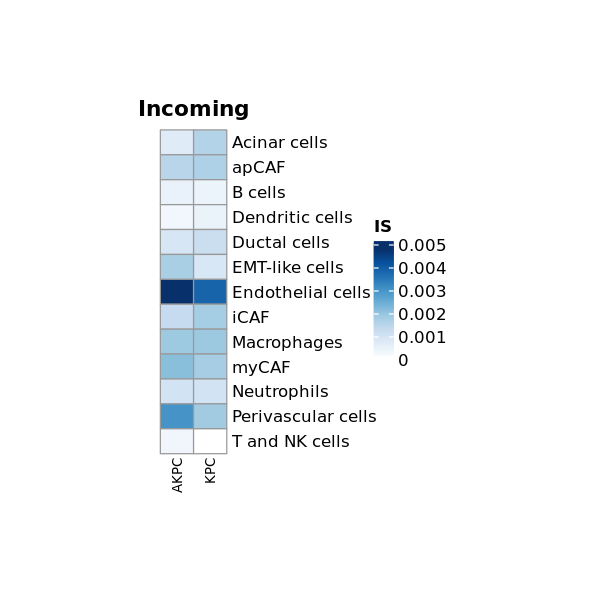

In [107]:
p.incoming

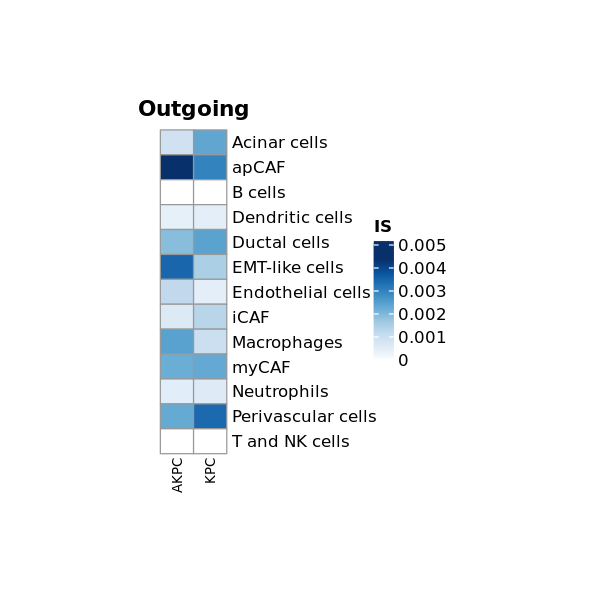

In [108]:
p.outgoing

In [28]:
sessionInfo()